# Trends and Analysis of eCommerce Data

## CSPB 4502 Spring 2024 - Group 9

Francesca Barrios   
frba7936@colorado.edu

Laura Brown   
labr1398@colorado.edu

Seth Ely  
seel6470@colorado.edu

Darby Hansen  
daha2377@colorado.edu 

## Data Cleaning

The first step is to download the dataset into a useable format with this notebook using the Pandas library. This is easier said than done, since the data for each month is about 2 to 3 Gb each in its compressed form, and joining the data into one dataframe is causing the kernel to crash.

To begin with, we can create a sample dataset from the entire dataset locally and upload that file to our github repo.

In [11]:
import pandas as pd
import gzip
import matplotlib.pyplot as plt


_(markdown cell since data files are stored locally and code will fail if run in environment)_

```python
# List of file names for each dataset month
local_file_paths = [
    './2019-Oct.csv.gz',
    './2019-Nov.csv.gz',
    './2019-Dec.csv.gz',
    './2020-Jan.csv.gz',
    './2020-Feb.csv.gz',
    './2020-Mar.csv.gz',
    './2020-Apr.csv.gz'
]

sample_df = pd.DataFrame()

for file_path in local_file_paths:
    sample_df = pd.concat([sample_df, pd.read_csv(file_path, compression='gzip').sample(n=50000)])

# Write sampled data to a new CSV file
sample_df.to_csv('./all_months_sampled.csv.gz', index=False, compression='gzip')
```

We can then find some preliminary information using this sample dataset.

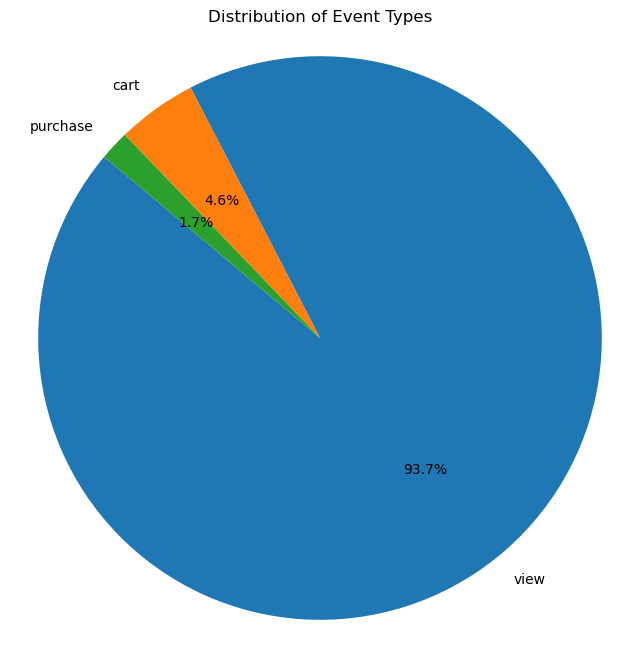

In [12]:
sample_df = pd.read_csv('./all_months_sampled.csv.gz',compression='gzip')

event_counts = sample_df['event_type'].value_counts()


plt.figure(figsize=(8, 8))
plt.pie(event_counts, labels=event_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Event Types')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

An important understanding of our dataset is that the event_types are mostly views, with a very minor percentage being purchases. Since most of our questions involve looking specifically at purchases, we can use this information to reduce the size of the dataset. We can iterate through each local file again, this time only taking entries where the event_types are 'purchase'

_(markdown cell since data files are stored locally and code will fail if run in environment)_

```python
purchased_entries = pd.DataFrame()

# List of file names for each month
file_paths = [
    './2019-Oct.csv.gz',
    './2019-Nov.csv.gz',
    './2019-Dec.csv.gz',
    './2020-Jan.csv.gz',
    './2020-Feb.csv.gz',
    './2020-Mar.csv.gz',
    './2020-Apr.csv.gz'
]

for file_path in file_paths:
    cur_df = pd.read_csv(file_path, compression='gzip')
    purchased_entries = pd.concat([purchased_entries, cur_df[cur_df['event_type'] == 'purchase']], ignore_index=True)


# Write to csv.gz
purchased_entries.to_csv('purchased_entries.csv.gz', compression='gzip')
```

This dataframe is still fairly massive and might need to be iterated over in chunks to avoid overflowing memory in online environments especially. Because of this, we can use the 'chunksize' attribute of pd.read_csv to iterate over it in chunks. Let's do this to gain further insight about NaN values

In [43]:
chunksize = 100000

nan_accum = pd.Series(dtype='float64')
len_accum = 0
for chunk in pd.read_csv('./purchased_entries.csv.gz', chunksize=chunksize):
    len_accum += len(chunk)
    nan_accum = nan_accum.add(chunk.isnull().sum(), fill_value=0)

In [44]:
print('There are',len_accum,'rows in the purchased_entries.csv.gz dataset\n\nHere is the percentage of NaN values in relation to entries:')
100 * nan_accum / len_accum

There are 6848824 rows in the purchased_entries.csv.gz dataset

Here is the percentage of NaN values in relation to entries:


event_time        0.000000
event_type        0.000000
product_id        0.000000
category_id       0.000000
category_code    11.214480
brand             7.726100
price             0.000000
user_id           0.000000
user_session      0.000058
dtype: float64

We can see that 7.7% of all brands are made up by NaN values and 11% of category codes are NaNs. There are a very small amount of user_session data points that are NaN as well. It would be helpful to determine how many entries have both NaN category_codes and NaN brand features.

In [45]:
chunksize = 100000
cat_and_brand_nans = 0
len_accum = 0

# Iterate through the CSV file in chunks
for chunk in pd.read_csv('./purchased_entries.csv.gz', chunksize=chunksize):
    # Count the total number of rows in the chunk
    len_accum += len(chunk)
    
    # Filter the chunk to include only rows where both 'category_code' and 'brand' are NaN
    cat_and_brand_nans += (chunk['category_code'].isna() & chunk['brand'].isna()).sum()


In [55]:
# create dataframe to show this as a 2x2 table (columns not NaN, Nan; rows: category_code, brand)

print('number of entires where both category_code and brand are NaN:',cat_and_brand_nans)
print('percentage of category_code NaNs that also have NaN brand:',100* cat_and_brand_nans / nan_accum['category_code'],'%')
print('percentage across all Brand values that have a NaN value and a valid category_code:', 100*(nan_accum['brand'] - cat_and_brand_nans)/ len_accum,'%')
print('percentage across all category_code values that have a NaN value and a valid brand value:', 100*(nan_accum['category_code'] - cat_and_brand_nans)/ len_accum,'%')

number of entires where both category_code and brand are NaN: 156309
percentage of category_code NaNs that also have NaN brand: 20.351144441840482 %
percentage across all Brand values that have a NaN value and a valid category_code: 5.443825100484404 %
percentage across all category_code values that have a NaN value and a valid brand value: 8.932205003369921 %


It looks like 20% of the category_code NaN entries also do not have the brand value. Since these entries would have only the product_id to go off of (a numerical categorical value that has little meaning) we can safely drop these values as they would have little information for us.

With this in mind, only 5% of all remaining brand entries will have valid category codes and only 9% of all remaining category_code entries will have a valid brand value. Because of this, we may be able to remove any NaNs for category_code, brand, and user_session while still retaining a vast majority of the variability of our data.

_(this code seems to not work in the online version of JupyterHub, but it can be run offline)_
```python
chunksize = 100000

purchased_entries = pd.DataFrame()

for chunk in pd.read_csv('./purchased_entries.csv.gz', chunksize=chunksize):
    purchased_entries = pd.concat([purchased_entries, chunk.dropna()])

# Write over purchased_entries.csv.gz
purchased_entries.to_csv('purchased_entries.csv.gz', compression='gzip', index=False)
```

We will also need to convert the event_time column from a string data type to a datetime type to gain insight into purchases over time and be able to create graphs using this column.

```python
chunksize = 100000

purchased_entries = pd.DataFrame()

for chunk in pd.read_csv('./purchased_entries.csv.gz', chunksize=chunksize):
    # Convert 'event_time' column to datetime format
    chunk['event_time'] = pd.to_datetime(chunk['event_time'])
    purchased_entries = pd.concat([purchased_entries, chunk])

# Write over purchased_entries.csv.gz
purchased_entries.to_csv('purchased_entries_clean.csv.gz', compression='gzip', index=False)
```

With these changes, our data is now clean and ready to be worked with.

___________________________________

# Everything past here is placeholder, exploratory code

All other brands must have null values across the board. We can manually add what we think these brands are and then we should have an accurate dataframe with category codes and brands for all entries.

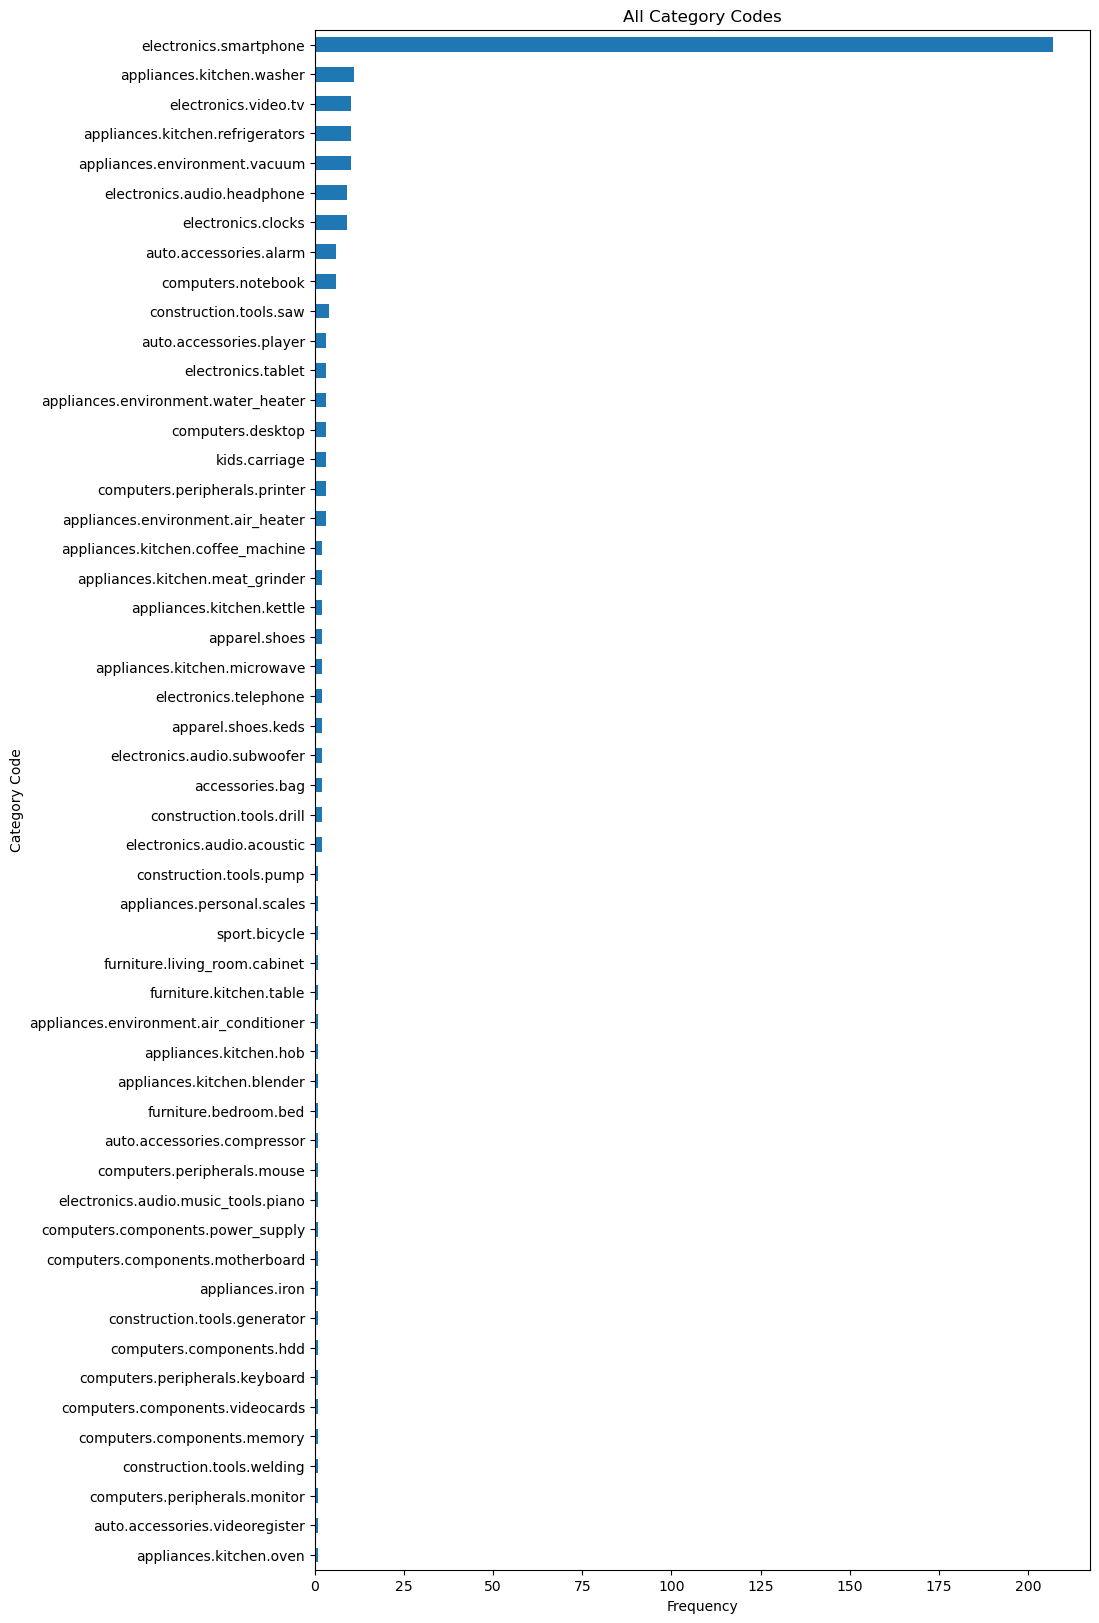

In [49]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame

# Calculate the frequency of each category code
category_counts = df['category_code'].value_counts()

# Plot a horizontal bar chart
plt.figure(figsize=(10, 20))
category_counts.plot(kind='barh')
plt.title('All Category Codes')
plt.xlabel('Frequency')
plt.ylabel('Category Code')
plt.gca().invert_yaxis()  # Invert y-axis to display highest frequency at the top
plt.show()

We can see the plurality of all purchases are smart phones, with the closest second being TV's. Let's

In [12]:
# turn event_time into true datetime format
df['event_time'] = pd.to_datetime(df['event_time'])

# create two new columns, date and time with parsed data
df['date'] = df['event_time'].dt.date
df['time'] = df['event_time'].dt.time
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,date,time
0,2019-11-01 00:00:00+00:00,view,1003461,2053013555631882655,electronics.smartphone,xiaomi,489.07,520088904,4d3b30da-a5e4-49df-b1a8-ba5943f1dd33,2019-11-01,00:00:00
1,2019-11-01 00:00:00+00:00,view,5000088,2053013566100866035,appliances.sewing_machine,janome,293.65,530496790,8e5f4f83-366c-4f70-860e-ca7417414283,2019-11-01,00:00:00
2,2019-11-01 00:00:01+00:00,view,17302664,2053013553853497655,creed,NaN,28.31,561587266,755422e7-9040-477b-9bd2-6a6e8fd97387,2019-11-01,00:00:01
3,2019-11-01 00:00:01+00:00,view,3601530,2053013563810775923,appliances.kitchen.washer,lg,712.87,518085591,3bfb58cd-7892-48cc-8020-2f17e6de6e7f,2019-11-01,00:00:01
4,2019-11-01 00:00:01+00:00,view,1004775,2053013555631882655,electronics.smartphone,xiaomi,183.27,558856683,313628f1-68b8-460d-84f6-cec7a8796ef2,2019-11-01,00:00:01


In [14]:
# Count NaN values by column
nan_counts = df.isna().sum()

# Display the number of NaNs by column
print(nan_counts/len(df))

event_time       0.000000
event_type       0.000000
product_id       0.000000
category_id      0.000000
category_code    0.193548
brand            0.354839
price            0.000000
user_id          0.000000
user_session     0.193548
date             0.000000
time             0.000000
dtype: float64


In [16]:
# deal with missing values
# drop NaN rows?
# replace NaN with 'unkown'?
# impute values?
    # with mode of column?

In [15]:
# Count duplicate entries
duplicate_count = df.duplicated().sum()

# Display the number of duplicate entries
print("Number of duplicate entries:", duplicate_count)


Number of duplicate entries: 0


## Filter and Group Dataframe

The following cell will filter the data to only items that were purchased and then group them by brand, product_id, and category_id features. These grouped objects will be used for many of the questions our project seeks to answer.

In [26]:
import matplotlib.pyplot as plt

# Step 1: Filter by 'event_type' equal to 'purchase'
filtered_df = df[df['event_type'] == 'purchase']

# Step 2: Group by 'brand' and calculate the sum of 'price'
brand_grouped = filtered_df.groupby('brand')['price']

# Step 3: Group by 'product_id' and calculate the sum of 'price'
product_grouped = filtered_df.groupby('product_id')['price']

# Step 4: Group by 'category' and calculate the sum of 'price'
category_grouped = filtered_df.groupby('category_id')['price']

### Which brands, items, or item categories exhibit the highest volume of sales during the specified period? 

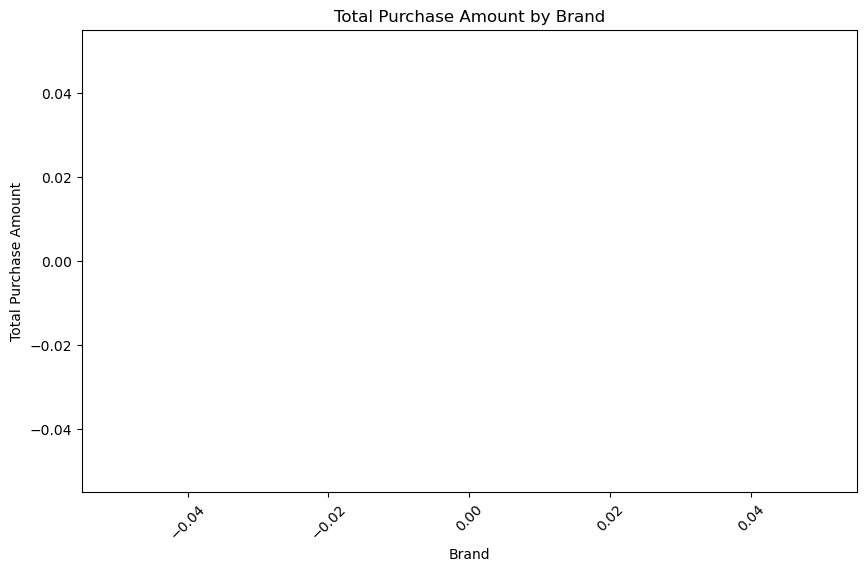

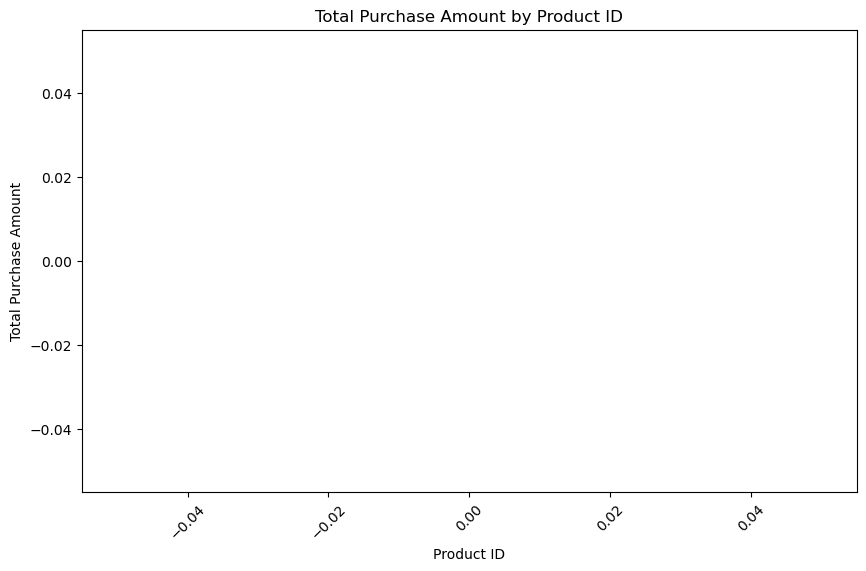

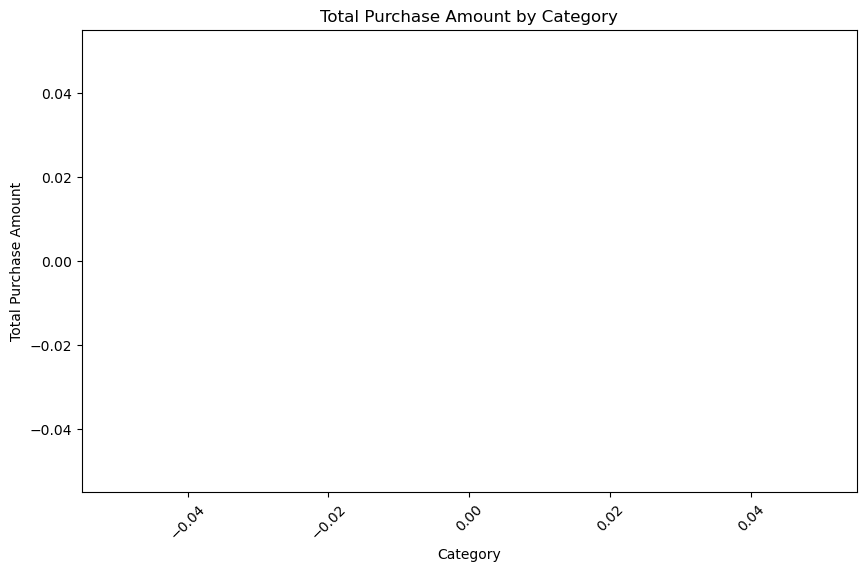

In [27]:
# Step 5: Visualization
# Visualize results for brand
plt.figure(figsize=(10, 6))
plt.bar(brand_grouped.sum().reset_index()['brand'], brand_grouped.sum().reset_index()['price'])
plt.title('Total Purchase Amount by Brand')
plt.xlabel('Brand')
plt.ylabel('Total Purchase Amount')
plt.xticks(rotation=45)
plt.show()

# Visualize results for product_id
plt.figure(figsize=(10, 6))
plt.bar(product_grouped.sum().reset_index()['product_id'], product_grouped.sum().reset_index()['price'])
plt.title('Total Purchase Amount by Product ID')
plt.xlabel('Product ID')
plt.ylabel('Total Purchase Amount')
plt.xticks(rotation=45)
plt.show()

# Visualize results for category
plt.figure(figsize=(10, 6))
plt.bar(category_grouped.sum().reset_index()['category_id'], category_grouped.sum().reset_index()['price'])
plt.title('Total Purchase Amount by Category')
plt.xlabel('Category')
plt.ylabel('Total Purchase Amount')
plt.xticks(rotation=45)
plt.show()

### Are there discernible trends in sales performance across different brands and categories? 

In [12]:
# graph brands/categories over time
# (day/week/month whichever works best considering the large amount of entries)

### Among the features of brands, items, or item categories, which ones demonstrate the highest purchases per view ratio? 

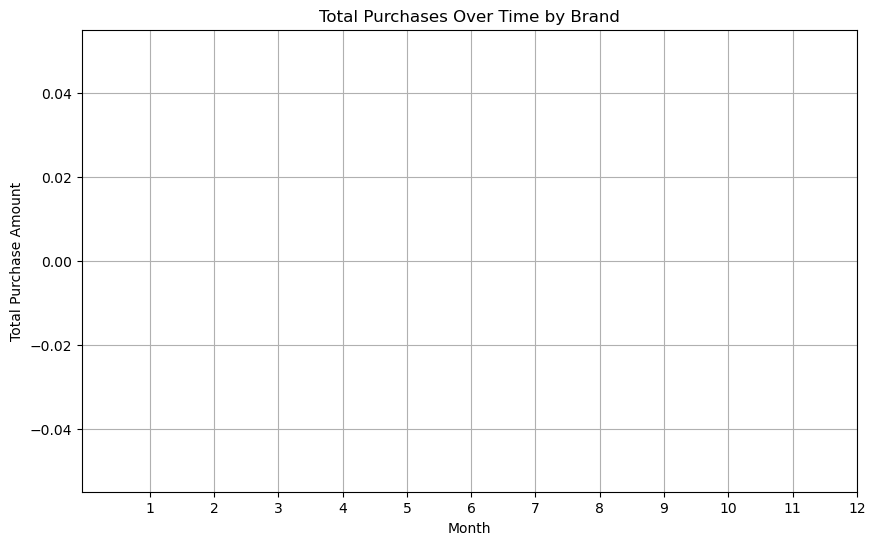

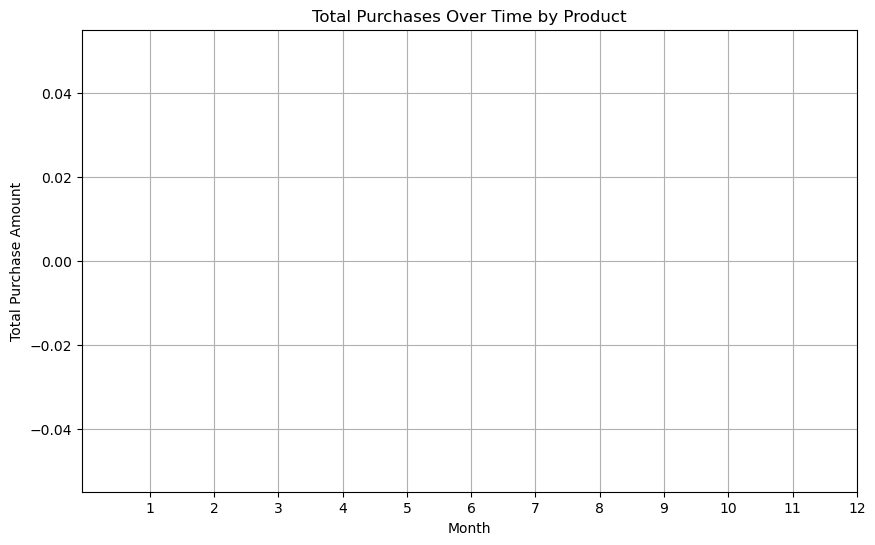

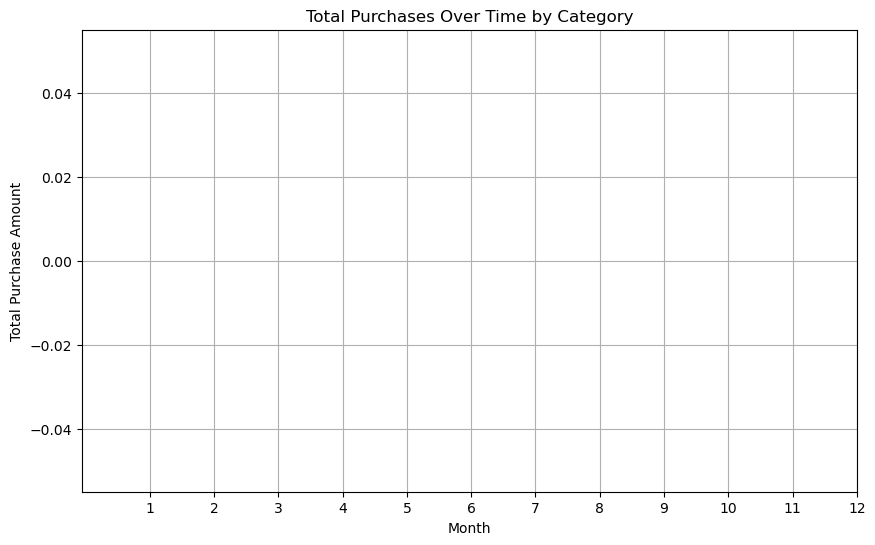

In [28]:
# Step 1: Extract month from 'event_time' using a lambda function
filtered_df['event_month'] = filtered_df['event_time'].apply(lambda x: x.month)

# Step 2: Group by month and calculate the sum of 'price'

# For brand_grouped
brand_monthly_total = filtered_df.groupby(filtered_df['event_month'])['price'].sum()

# For product_grouped
product_monthly_total = filtered_df.groupby(filtered_df['event_month'])['price'].sum()

# For category_grouped
category_monthly_total = filtered_df.groupby(filtered_df['event_month'])['price'].sum()

# Step 3: Plot total purchases over time

# For brand_grouped
plt.figure(figsize=(10, 6))
plt.plot(brand_monthly_total.index, brand_monthly_total.values, marker='o')
plt.title('Total Purchases Over Time by Brand')
plt.xlabel('Month')
plt.ylabel('Total Purchase Amount')
plt.xticks(range(1, 13))
plt.grid(True)
plt.show()

# For product_grouped
plt.figure(figsize=(10, 6))
plt.plot(product_monthly_total.index, product_monthly_total.values, marker='o')
plt.title('Total Purchases Over Time by Product')
plt.xlabel('Month')
plt.ylabel('Total Purchase Amount')
plt.xticks(range(1, 13))
plt.grid(True)
plt.show()

# For category_grouped
plt.figure(figsize=(10, 6))
plt.plot(category_monthly_total.index, category_monthly_total.values, marker='o')
plt.title('Total Purchases Over Time by Category')
plt.xlabel('Month')
plt.ylabel('Total Purchase Amount')
plt.xticks(range(1, 13))
plt.grid(True)
plt.show()

### What factors contribute to the rate of purchases per view of these brands, items, or item categories? 

In [14]:
# Interpret

### Can brand type lead to customer retention (customer’s purchase frequency after initial purchase)? 

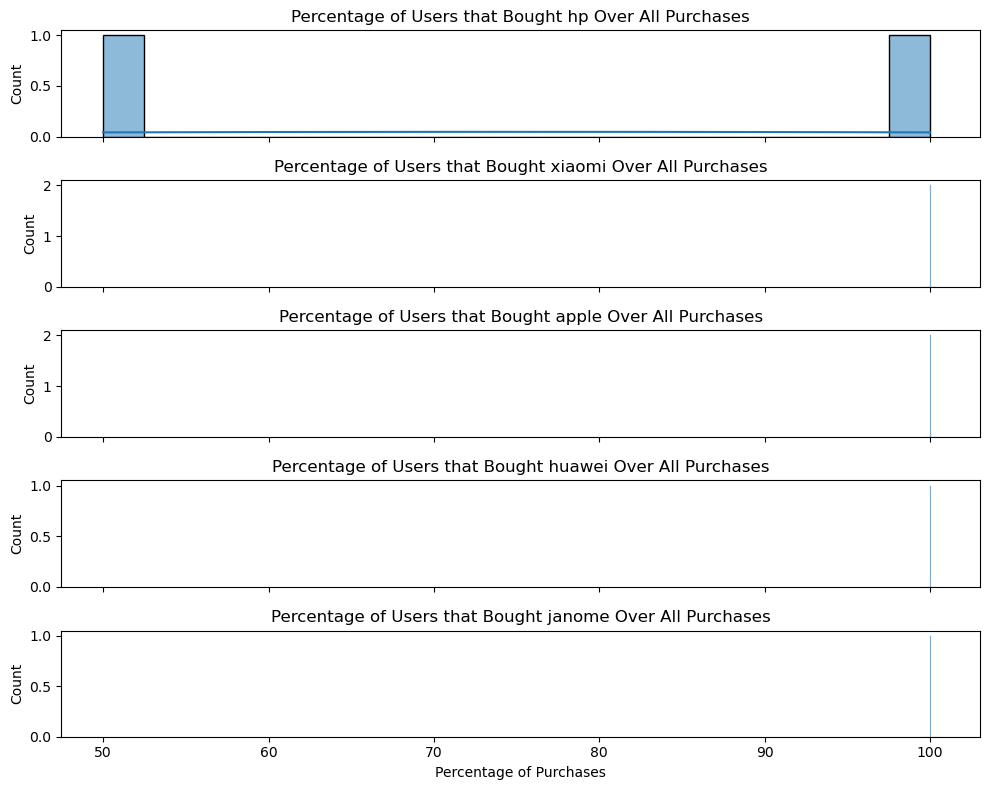

In [30]:
import seaborn as sns

# Step 1: Find the top brands
top_brands = df['brand'].value_counts().head(5).index  # Change '5' to the number of top brands you want

# Step 2: Create subplots for each top brand
fig, axes = plt.subplots(len(top_brands), 1, figsize=(10, 8), sharex=True)

# Step 3: Plot histograms for each top brand
for i, brand in enumerate(top_brands):
    # Filter dataframe for the current brand
    brand_df = df[df['brand'] == brand]
    
    # Group by user_id and count the number of purchases
    purchase_count_per_user = brand_df.groupby('user_id').size()
    
    # Calculate the percentage of purchases for the current brand over all purchases by each user
    percentage_per_user = (purchase_count_per_user / df.groupby('user_id').size()) * 100
    
    # Plot histogram
    sns.histplot(percentage_per_user, bins=20, kde=True, ax=axes[i])
    axes[i].set_title(f'Percentage of Users that Bought {brand} Over All Purchases')
    axes[i].set_xlabel('Percentage of Purchases')
    axes[i].set_ylabel('Count')

# Adjust layout
plt.tight_layout()
plt.show()

### Can seasonal patterns be identified within the 7-month window of the dataset? 

In [16]:
# filter by purchased


# graph top brands/categories over time
# (day/week/month whichever works best considering the large amount of entries)

### How do seasonal variations impact the sales and purchasing behaviors of consumers across individual brands and categories? 

### Can we find any trending patterns within our item sets outside of seasonal trend behavior – which can be used to predict popularity purchase windows? 

## Evaluation

### Accuracy

In [17]:
# Predictive model with target class event_type (purchased = 1, view/remove from cart = 0)

In [18]:
# Cluster algorithm for-you recommendations

### Relevance

_discuss findings in terms of real-word needs_

### Interpretability

_discuss visualizations and how understandable the findings are to the general public_